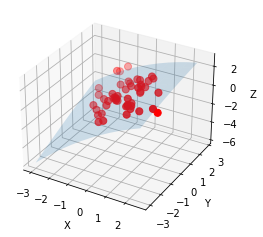

In [55]:
# https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
#ax.axis('equal')
ax.axis('tight')
plt.show()

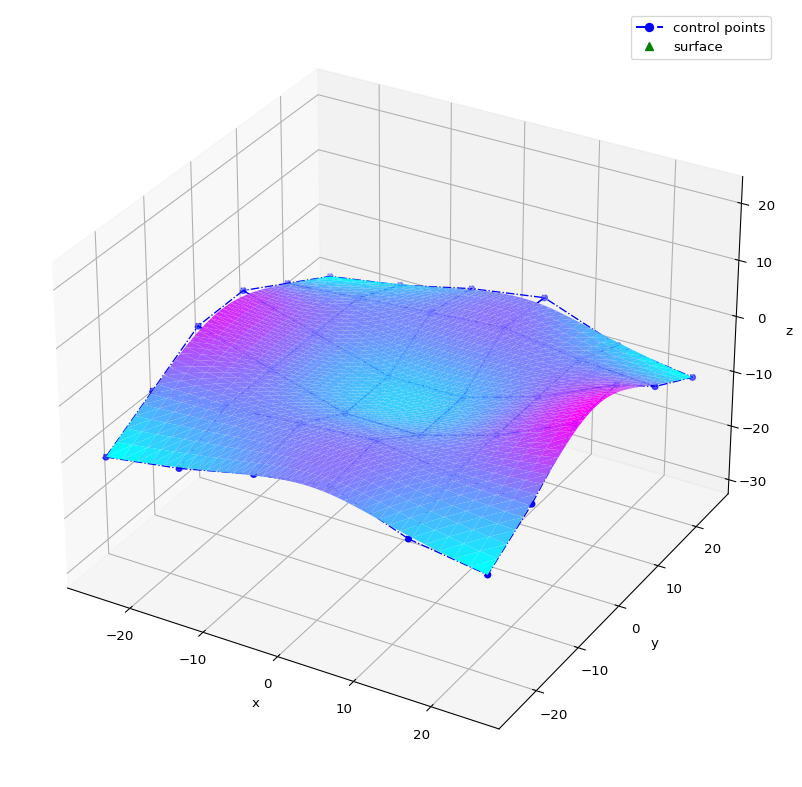

In [71]:
from geomdl import BSpline
from geomdl.visualization import VisMPL

# Control points
ctrlpts = [
    [[-25.0, -25.0, -10.0], [-25.0, -15.0, -5.0], [-25.0, -5.0, 0.0], [-25.0, 5.0, 0.0], [-25.0, 15.0, -5.0], [-25.0, 25.0, -10.0]],
    [[-15.0, -25.0, -8.0], [-15.0, -15.0, -4.0], [-15.0, -5.0, -4.0], [-15.0, 5.0, -4.0], [-15.0, 15.0, -4.0], [-15.0, 25.0, -8.0]],
    [[-5.0, -25.0, -5.0], [-5.0, -15.0, -3.0], [-5.0, -5.0, -8.0], [-5.0, 5.0, -8.0], [-5.0, 15.0, -3.0], [-5.0, 25.0, -5.0]],
    [[5.0, -25.0, -3.0], [5.0, -15.0, -2.0], [5.0, -5.0, -8.0], [5.0, 5.0, -8.0], [5.0, 15.0, -2.0], [5.0, 25.0, -3.0]],
    [[15.0, -25.0, -8.0], [15.0, -15.0, -4.0], [15.0, -5.0, -4.0], [15.0, 5.0, -4.0], [15.0, 15.0, -4.0], [15.0, 25.0, -8.0]],
    [[25.0, -25.0, -10.0], [25.0, -15.0, -5.0], [25.0, -5.0, 2.0], [25.0, 5.0, 2.0], [25.0, 15.0, -5.0], [25.0, 25.0, -10.0]]
]

# Create a BSpline surface
surf = BSpline.Surface()

# Set degrees
surf.degree_u = 3
surf.degree_v = 3

# Set control points
surf.ctrlpts2d = ctrlpts

# Set knot vectors
surf.knotvector_u = [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0]
surf.knotvector_v = [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0]

# Set evaluation delta
surf.delta = 0.025

# Evaluate surface points
surf.evaluate()

# Import and use Matplotlib's colormaps
from matplotlib import cm

# Plot the control points grid and the evaluated surface
surf.vis = VisMPL.VisSurface()
surf.render(colormap=cm.cool)

In [1]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
from skimage import measure
import skimage
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import SimpleITK as sitk

# ref https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b
def imread(fpath):
    if os.path.isdir(fpath):
        dicom_names = [os.path.join(fpath,x) for x in os.listdir(fpath)]
        mylist = []
        for x in dicom_names:
            ds = pydicom.dcmread(x)
            mylist.append( (ds.InstanceNumber,x))
        
        dicom_names = [x[1] for x in sorted(mylist,key=lambda x: x[0])]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image,origin,direction):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    out_spacing=[1.0, 1.0, 1.0]
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(direction)
    resample.SetOutputOrigin(origin)
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    sampler = None
    if sampler == 'nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


In [3]:
import os
import requests
local_filename = 'img.zip'
if not os.path.exists(local_filename):
    uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075"
    r=requests.get(f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={uid}")
    if r.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    del r

In [4]:
# !mkdir -p img && unzip img.zip -d img

(0.609375, 0.609375, 1.25) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)


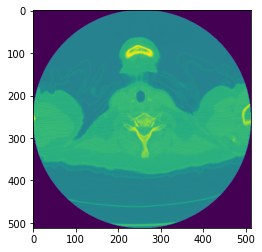

In [5]:
#itk_image = imread('img')
itk_image = imread('image.nii.gz')
arr = sitk.GetArrayFromImage(itk_image)    
spacing = itk_image.GetSpacing()
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

#imwrite('image.nii.gz',arr,spacing,origin,direction)

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())

In [6]:
# create lof.nii.gz with itk-snap

In [7]:
roi_image = imread('lof.nii.gz')
arr = sitk.GetArrayFromImage(roi_image)
print(np.sum(arr))

4534


In [9]:
itk_image = imread('image.nii.gz')

spacing = (1,1,1)
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()

#size = new_img.GetSize()
size = np.array(list(itk_image.GetSize()))*np.array(list(itk_image.GetSpacing()))
size = size.astype(int).tolist()
size = tuple(size)
print(size)

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)

new_img = resample.Execute(itk_image)
arr = sitk.GetArrayFromImage(new_img)

spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

resample.SetDefaultPixelValue(roi_image.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkNearestNeighbor)

roi_image = imread('lof.nii.gz')
new_roi = resample.Execute(roi_image)

spacing = new_roi.GetSpacing()
origin = new_roi.GetOrigin()
direction = new_roi.GetDirection()
size = new_roi.GetSize()

print(spacing,origin,direction,size)

mask_image = imread('llung.nii.gz')
new_mask = resample.Execute(mask_image)


(312, 312, 301)
(1.0, 1.0, 1.0) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (312, 312, 301)
(1.0, 1.0, 1.0) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (312, 312, 301)


1874
(301, 312, 312)


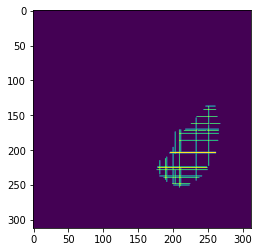

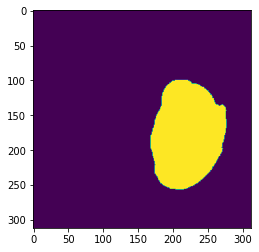

In [10]:
arr_roi = sitk.GetArrayFromImage(new_roi)
arr_mask = sitk.GetArrayFromImage(new_mask)
print(np.sum(arr_roi>0))
plt.figure(0)
plt.imshow(np.max(arr_roi,axis=0))
print(arr_roi.shape)
plt.figure(1)
plt.imshow(np.max(arr_mask,axis=0))

(1874, 3)


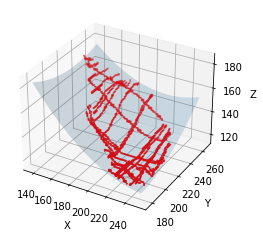

In [69]:
_data = np.array(np.where(arr_roi==1)).T
data = np.zeros(_data.shape)
data[:,0]=_data[:,1]
data[:,1]=_data[:,2]
data[:,2]=_data[:,0]

print(data.shape)
# regular grid covering the domain of the data
X,Y = np.meshgrid(
    np.arange(np.min(data[:,0]),np.max(data[:,0]),1),
    np.arange(np.min(data[:,1]),np.max(data[:,1]),1) )
XX = X.flatten()
YY = Y.flatten()

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,1], data[:,2], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,0])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=1)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
#ax.axis('equal')
ax.axis('tight')
plt.show()

In [70]:
arr = sitk.GetArrayFromImage(new_roi).astype(int)
_zs,_xs,_ys = np.where(arr==1)
ps = []
for x,y,z in zip(_xs,_ys,_zs):
    #p = new_roi.TransformContinuousIndexToPhysicalPoint((float(x),float(y),float(z)))
    p = (float(x),float(y),float(z))
    ps.append(p)
ps = np.array(ps)
print(ps.shape)

(1874, 3)


In [72]:
from geomdl import fitting
from geomdl import BSpline
from geomdl.visualization import VisMPL

In [73]:
mylist = []
for x in np.unique(ps[:,0]):
    ind = ps[:,0]==x
    myline=ps[ind,:]
    if myline.shape[0] > 3:
        mylist.append(myline)
        #print(myline.shape)

In [52]:
#surf = fitting.approximate_surface(ps, 10,10,2,2)

surf = BSpline.Surface()

# Set degrees
surf.degree_u = 3
surf.degree_v = 3

# Set control points
surf.ctrlpts2d = mylist

# Set knot vectors
surf.knotvector_u = [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0]
surf.knotvector_v = [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0]

# Set evaluation delta
surf.delta = 0.025

# Evaluate surface points
surf.evaluate()


vis_comp = VisMPL.VisCurve3D()
surf.vis = vis_comp
surf.render()


IndexError: index 4 is out of bounds for axis 0 with size 4

solution:
-0.307274 x + 0.214111 y + 152.653501 = z


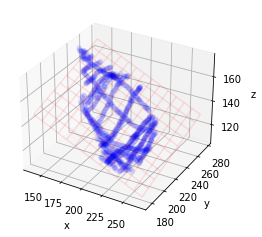

In [708]:
xs = ps[:,0]
ys = ps[:,1]
zs = ps[:,2]

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

print("solution:")
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors:")
#print(errors)
#print("residual:")
#print(residual)

# plot plane
X,Y = np.meshgrid(np.arange(np.min(xs),np.max(xs)+20,10),
                  np.arange(np.min(ys),np.max(ys)+20,10))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
        
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b',alpha=0.05)

ax.plot_wireframe(X,Y,Z, color='r',alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [709]:
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))

-0.307274 x + 0.214111 y + 152.653501 = z


In [710]:
# https://web.ma.utexas.edu/users/m408m/Display12-5-4.shtml
z_vec = np.array([fit[0,0], fit[1,0], -1])
z_vec = z_vec / (np.linalg.norm(z_vec) + 1e-16)
print(z_vec)

[-0.28775556  0.20051059 -0.93647864]


In [711]:
np.min(X),np.max(X),np.min(Y),np.max(Y)

(137.0, 267.0, 177.0, 277.0)

In [712]:
c00 = (X[0,0],Y[0,0],Z[0,0])
c10 = (X[-1,0],Y[-1,0],Z[-1,0])
c01 = (X[0,-1],Y[0,-1],Z[0,-1])
c11 = (X[-1,-1],Y[-1,-1],Z[-1,-1])
origin = c00
print(origin)
x_vec = np.array(c10)-np.array(c00)
x_vec = x_vec / (np.linalg.norm(x_vec) + 1e-16)
y_vec = np.array(c01)-np.array(c00)
y_vec = y_vec / (np.linalg.norm(y_vec) + 1e-16)

print(x_vec)
print(y_vec)
z_vec = np.cross(x_vec,y_vec)
print(z_vec)

direction = tuple(x_vec)+tuple(y_vec)+tuple(z_vec)

xsize = int(np.sqrt(np.sum(np.array(c00)-np.array(c01))**2))
ysize = int(np.sqrt(np.sum(np.array(c00)-np.array(c10))**2))

#origin = np.array(c00)-np.array([0,0,-20])
origin = c11
origin = tuple(list(origin))
spacing = (1,1,1)
zsize = 40
size = (xsize,ysize,zsize)
print(size)


(137.0, 177.0, 148.45464803919882)
[0.         0.97783736 0.20936596]
[ 0.95589133  0.         -0.29372057]
[-0.28721095  0.2001311  -0.93470625]
(90, 121, 40)


In [677]:
for p in [c00,c01,c10,c11]:
    print(p)

(137.0, 177.0, 148.45464803919882)
(267.0, 177.0, 108.50902538729106)
(137.0, 277.0, 169.86577091838438)
(267.0, 277.0, 129.92014826647662)


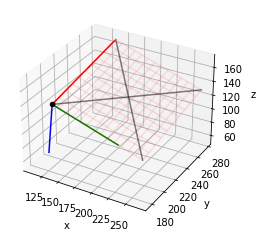

In [678]:
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')

ax.plot([c00[0],c11[0]],[c00[1],c11[1]],[c00[2],c11[2]],color='k',alpha=0.5)
ax.plot([c01[0],c10[0]],[c01[1],c10[1]],[c01[2],c10[2]],color='k',alpha=0.5)

c = 100
ax.plot([c00[0],c00[0]+c*x_vec[0]],[c00[1],c00[1]+c*x_vec[1]],[c00[2],c00[2]+c*x_vec[2]],color='r',alpha=1)
ax.plot([c00[0],c00[0]+c*y_vec[0]],[c00[1],c00[1]+c*y_vec[1]],[c00[2],c00[2]+c*y_vec[2]],color='g',alpha=1)
ax.plot([c00[0],c00[0]+c*z_vec[0]],[c00[1],c00[1]+c*z_vec[1]],[c00[2],c00[2]+c*z_vec[2]],color='b',alpha=1)


ax.scatter(c00[0],c00[1],c00[2],color='k',alpha=1)


ax.plot_wireframe(X,Y,Z, color='r',alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.axis('equal')
plt.show()

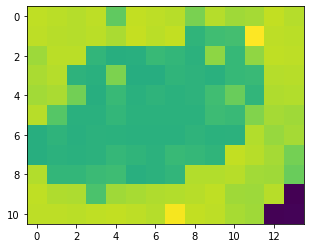

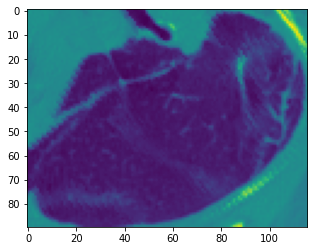

In [679]:
arr = sitk.GetArrayFromImage(new_img)

oblique = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        x,y,z = int(X[r,c]),int(Y[r,c]),int(Z[r,c])
        oblique[r,c]=arr[z,x,y]
plt.figure(0)
plt.imshow(oblique)

hdX,hdY = np.meshgrid(np.arange(np.min(xs),np.max(xs),1),
                  np.arange(np.min(ys),np.max(ys),1))

hdZ = np.zeros(hdX.shape)
for r in range(hdX.shape[0]):
    for c in range(hdX.shape[1]):
        hdZ[r,c] = fit[0] * hdX[r,c] + fit[1] * hdY[r,c] + fit[2]

hdoblique = np.zeros(hdX.shape)
for r in range(hdX.shape[0]):
    for c in range(hdX.shape[1]):
        x,y,z = int(hdX[r,c]),int(hdY[r,c]),int(hdZ[r,c])
        hdoblique[r,c]=arr[z,x,y]
plt.figure(1)
plt.imshow(hdoblique)

In [680]:
hdX.shape

(90, 116)

1386.0
1874


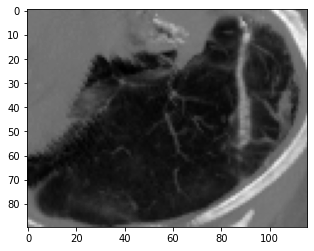

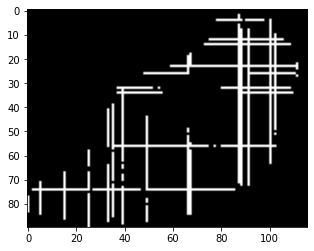

In [681]:
arr_roi = sitk.GetArrayFromImage(new_roi)
arr_img = sitk.GetArrayFromImage(new_img)

myshape = hdX.shape
myshape = list(myshape+(10,))
roi_oblique = np.zeros(myshape)
img_oblique = np.zeros(myshape)
for o in range(myshape[2]):
    for r in range(myshape[0]):
        for c in range(myshape[1]):
            x,y,z = int(hdX[r,c]),int(hdY[r,c]),int(hdZ[r,c])
            roi_oblique[r,c,o]=arr_roi[z+o-5,x,y]
            img_oblique[r,c,o]=arr_img[z+o-5,x,y]
            
plt.figure(0)
kwargs = dict(cmap='gray')#,vmin=-1024,vmax=-500)
plt.imshow(np.max(img_oblique,axis=-1),**kwargs)
plt.figure(1)
plt.imshow(np.max(roi_oblique,axis=-1),**kwargs)

print(np.sum(roi_oblique))
print(np.sum(sitk.GetArrayFromImage(new_roi)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


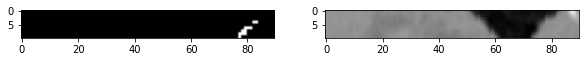

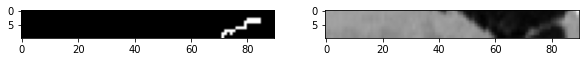

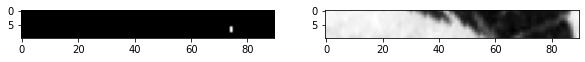

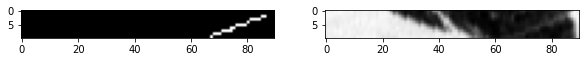

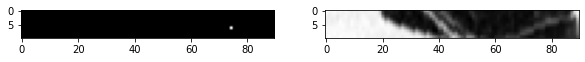

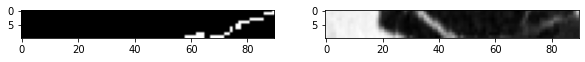

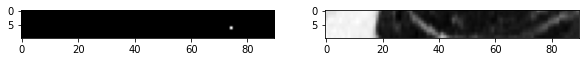

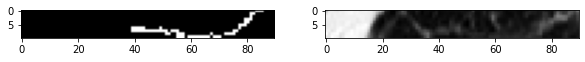

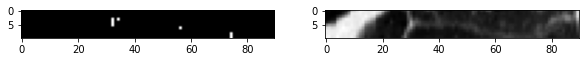

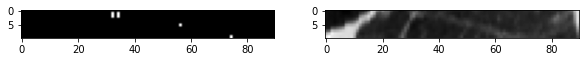

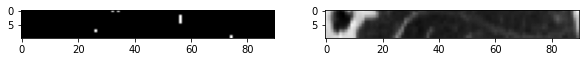

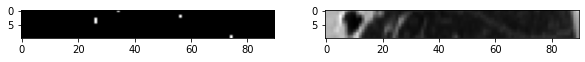

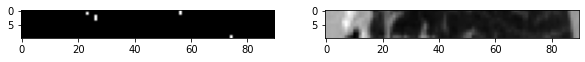

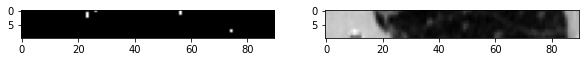

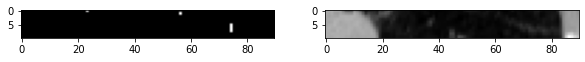

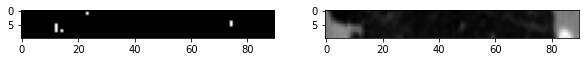

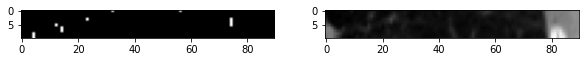

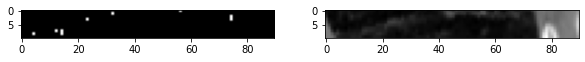

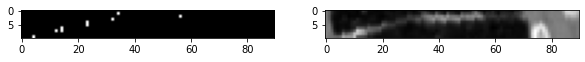

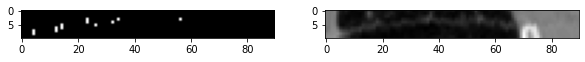

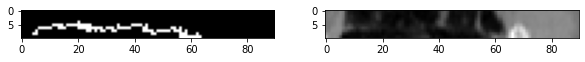

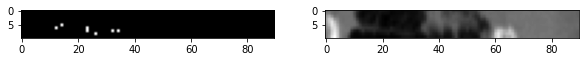

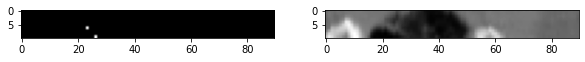

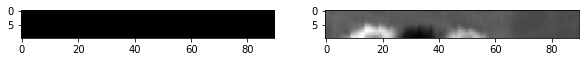

In [682]:
kwargs = {'cmap':'gray'}
for o in np.arange(0,hdoblique.shape[1],5):
    plt.figure(o,figsize=(10,5))
    plt.subplot(121)
    plt.imshow(roi_oblique[:,o,:].T,**kwargs)
    plt.subplot(122)
    plt.imshow(img_oblique[:,o,:].T,**kwargs)

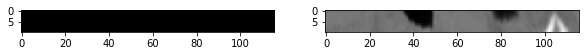

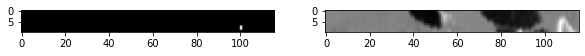

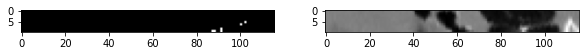

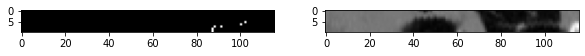

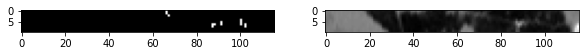

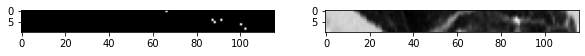

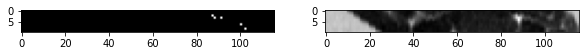

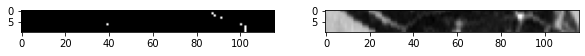

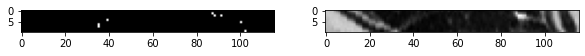

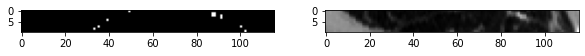

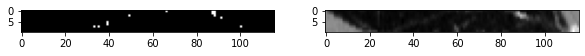

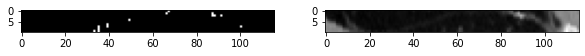

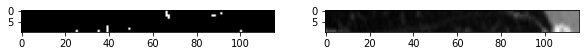

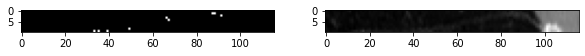

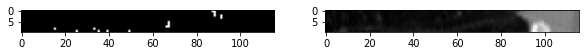

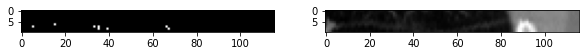

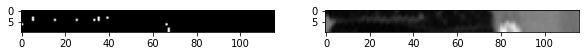

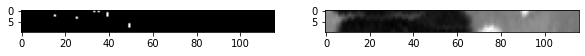

In [683]:
kwargs = {'cmap':'gray'}
for o in np.arange(0,hdoblique.shape[0],5):
    plt.figure(o,figsize=(10,5))
    plt.subplot(121)
    plt.imshow(roi_oblique[o,:,:].T,**kwargs)
    plt.subplot(122)
    plt.imshow(img_oblique[o,:,:].T,**kwargs)

(1.0, 1.0, 1.0) (267.0, 277.0, 129.92014826647662) (0.0, 0.9778373564418616, 0.2093659579463468, 0.9558913256004599, 0.0, -0.2937205706820605, -0.287210946368341, 0.20013110307694357, -0.9347062468708605) (90, 121, 40)
(1.0, 1.0, 1.0) (267.0, 277.0, 129.92014826647662) (0.0, 0.9778373564418616, 0.2093659579463468, 0.9558913256004599, 0.0, -0.2937205706820605, -0.287210946368341, 0.20013110307694357, -0.9347062468708605) (90, 121, 40)


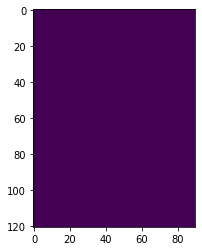

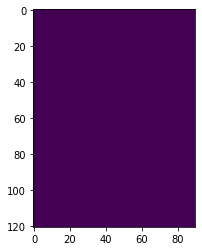

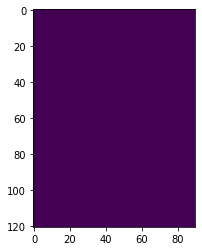

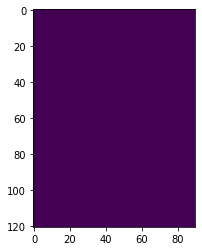

In [684]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
#resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetDefaultPixelValue(-2000)
resample.SetInterpolator(sitk.sitkBSpline)
new_img = resample.Execute(itk_image)


arr = sitk.GetArrayFromImage(new_img)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

print(spacing,origin,direction,size)
for i in np.arange(0,arr.shape[0],10):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze(),vmin=-1024,vmax=1024)

In [399]:
size = new_img.GetSize()
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()

arr=np.zeros(arr.shape)
img = sitk.GetImageFromArray(arr)
img.SetSpacing(spacing)
img.SetOrigin(origin)
img.SetDirection(direction)
writer = sitk.ImageFileWriter()    
writer.SetFileName('oblique.nii.gz')
writer.SetUseCompression(True)
writer.Execute(img)


(1.0, 1.0, 1.0) (66.33984375, -39.16015625, 1132.9273289466294) (0.0, 0.9995943734574947, -0.028479616432085825, 0.518870539811327, 0.0, 0.854852831144579, 0.8545060801463309, -0.014777233951735911, -0.5186600721482555) (238, 97, 40)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


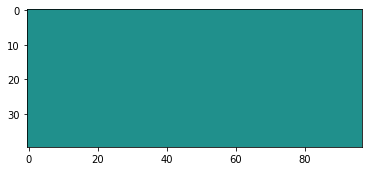

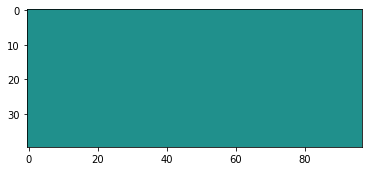

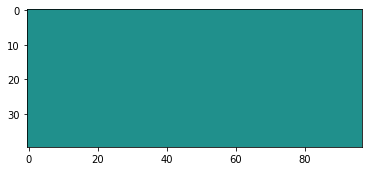

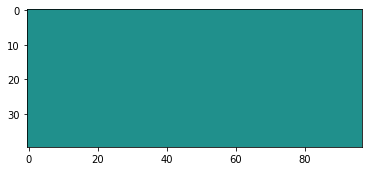

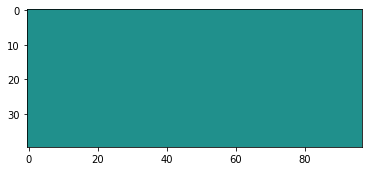

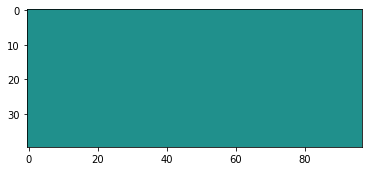

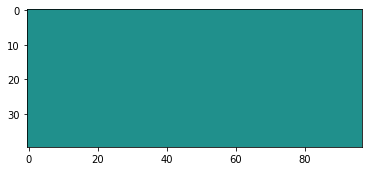

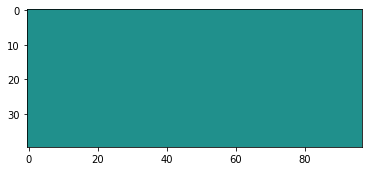

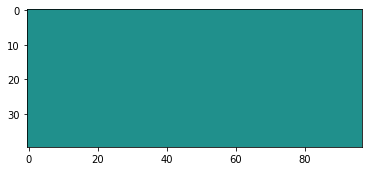

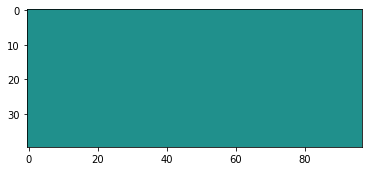

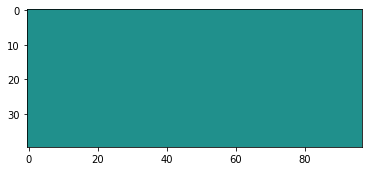

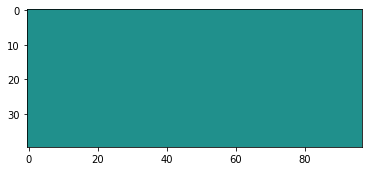

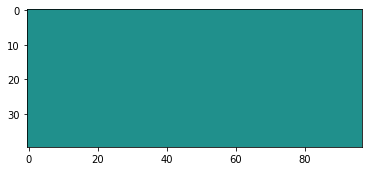

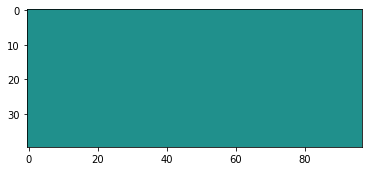

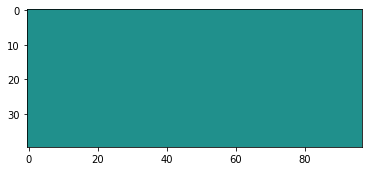

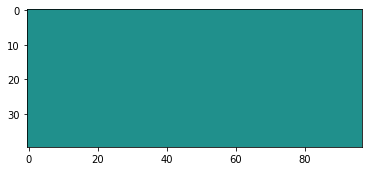

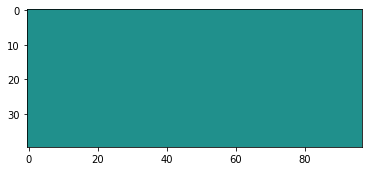

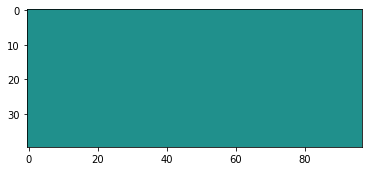

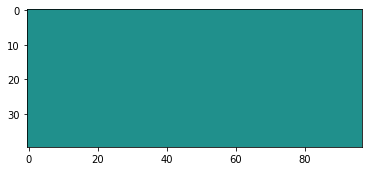

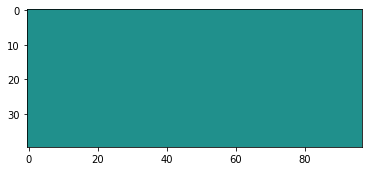

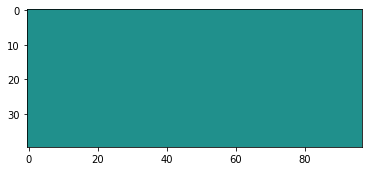

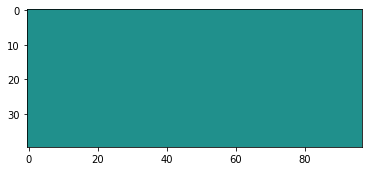

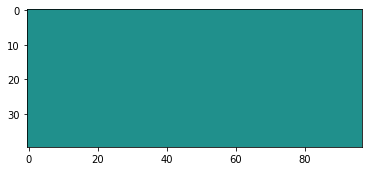

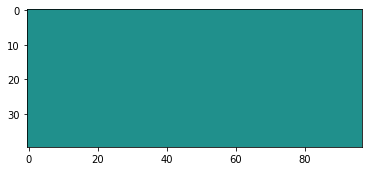

In [400]:
print(spacing,origin,direction,size)
for i in np.arange(0,arr.shape[2],10):
    plt.figure(i)
    plt.imshow(arr[:,:,i].squeeze(),vmin=-1024,vmax=1024)

(1.0, 1.0, 1.0) (-23.66015625, -139.16015625, 1007.4990843825564) (0.0, 0.9995943734574947, -0.028479616432085825, 0.518870539811327, 0.0, 0.854852831144579, 0.8545060801463309, -0.014777233951735911, -0.5186600721482555) (238, 97, 40)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


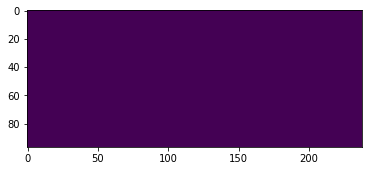

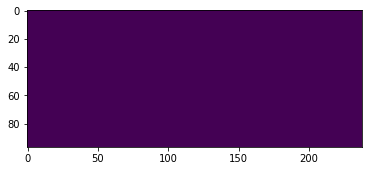

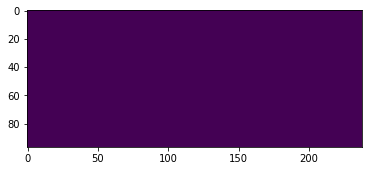

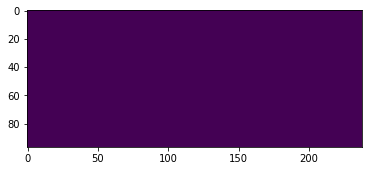

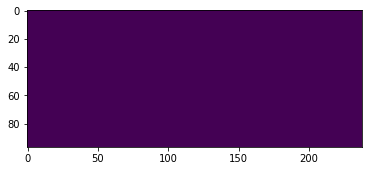

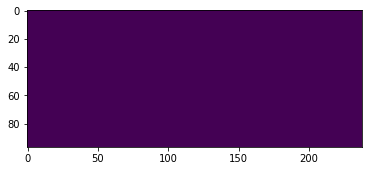

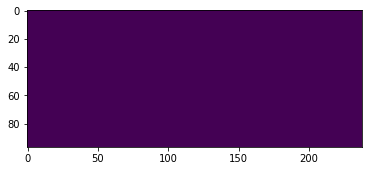

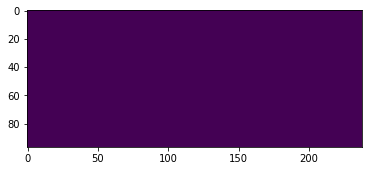

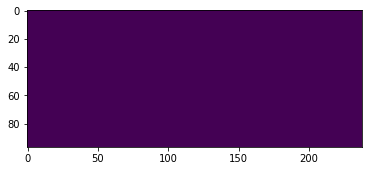

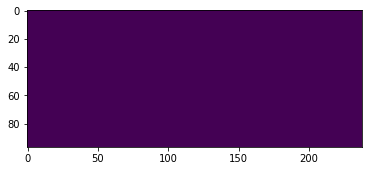

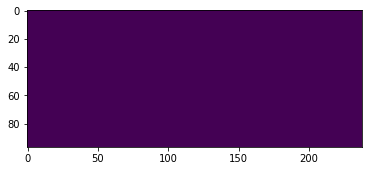

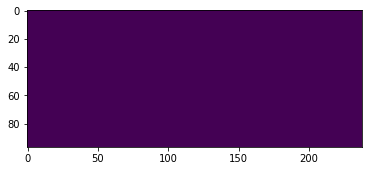

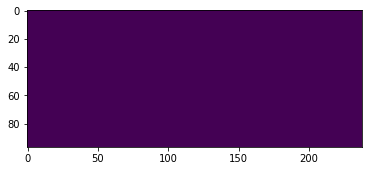

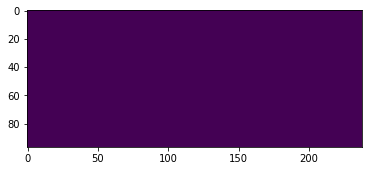

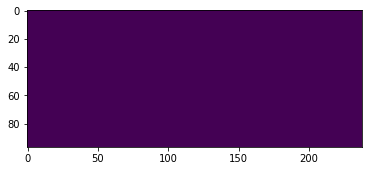

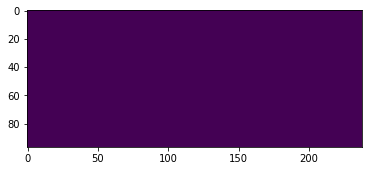

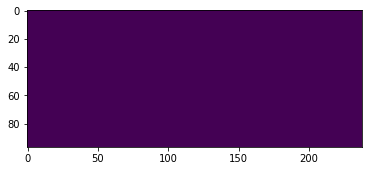

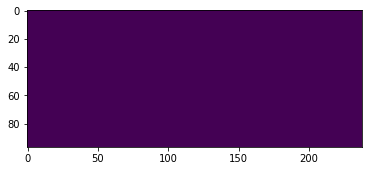

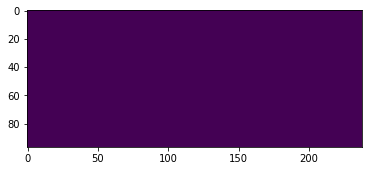

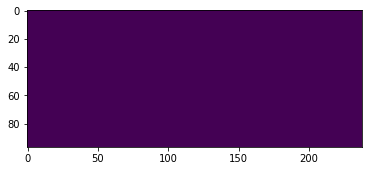

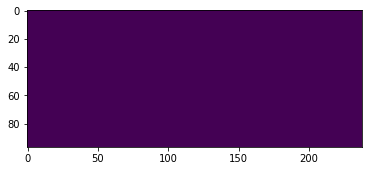

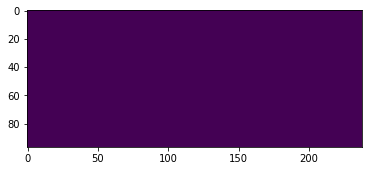

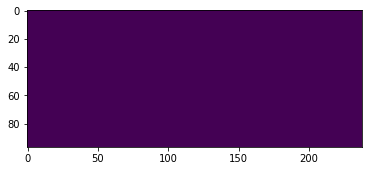

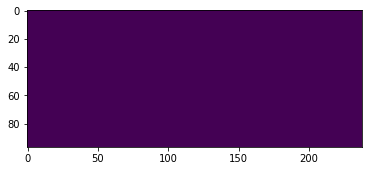

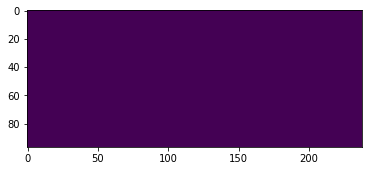

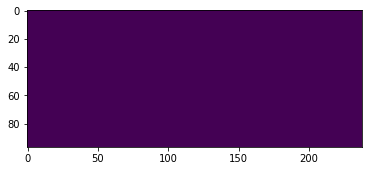

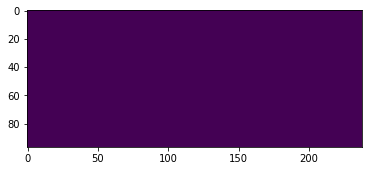

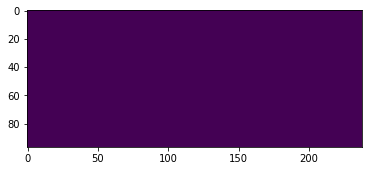

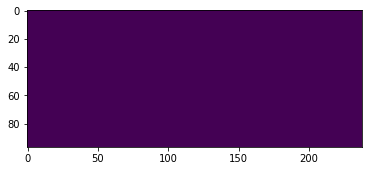

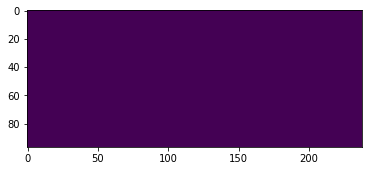

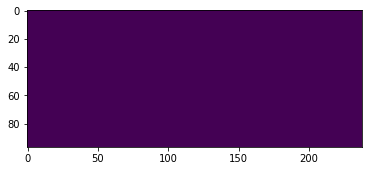

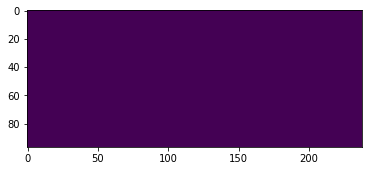

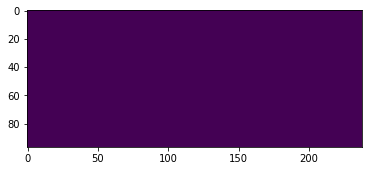

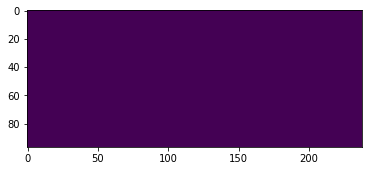

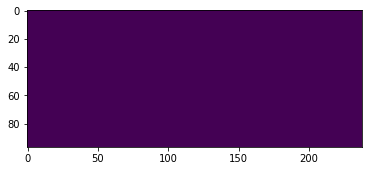

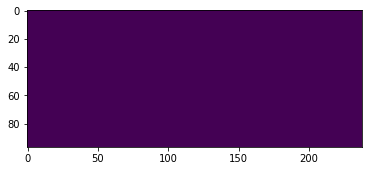

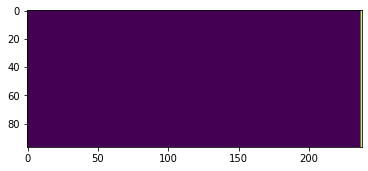

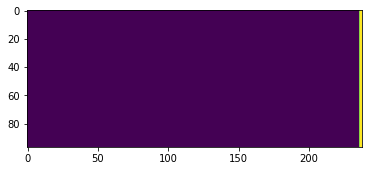

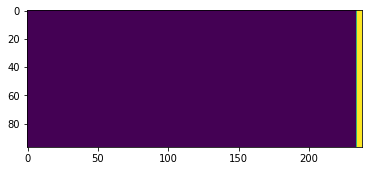

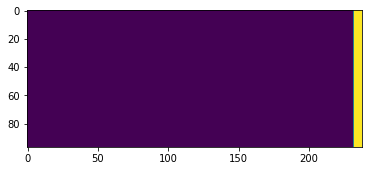

In [382]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(-1)
resample.SetInterpolator(sitk.sitkNearestNeighbor)
new_roi = resample.Execute(roi_image)

arr = sitk.GetArrayFromImage(new_roi)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)
for i in range(zsize):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze())